In [14]:
import tensorflow as tf
import tensorflow.contrib as tc
import numpy as np
import gym
import matplotlib.pyplot as plt
import seaborn as sns

from replay_buffer import ReplayBuffer

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
class Actor(object):
    def __init__(self, sess, nObs, nAct, actionBound, lr, tau, \
                 nodes, batchSize, trainable, layer_norm):
        self.sess = sess
        self.nObs = nObs
        self.nAct = nAct
        self.actionBound = actionBound
        self.lr = lr
        self.tau = tau
        self.nodes = nodes
        self.batchSize = batchSize
        self.trainable = trainable
        self.layer_norm = layer_norm
        
        with tf.variable_scope('actor'):
            self.obs, self.action, self.scaledAction = self.buildNet()
            
        self.netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'actor')
        
        with tf.variable_scope('target_actor'):
            self.target_obs, self.target_action, self.target_scaledAction = self.buildNet()
        
        self.target_netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'target_actor')
        self.update_target = \
            [self.target_netParams[i].assign(tf.multiply(self.netParams[i], self.tau) + \
                                             tf.multiply(self.target_netParams[i], 1. - self.tau))
                        for i in range(len(self.target_netParams))]
        
        # from critic with action taken
        self.actionGrads = tf.placeholder(tf.float32, [None, self.nAct], 'gradient')
        
        # actor gradients
        self.grads_ = tf.gradients(self.scaledAction, self.netParams, \
                                 -self.actionGrads)
        # normalized actor gradients by batchSize
        self.grads = list(map(lambda x: tf.div(x, self.batchSize), \
                             self.grads_))
        
        self.optimize = tf.train.AdamOptimizer(self.lr).apply_gradients(\
                        zip(self.grads, self.netParams))
        
    def buildNet(self):
        obs = tf.placeholder(tf.float32, [None, self.nObs], 'observation')

        
        W1 = tf.get_variable("W1", [self.nObs, self.nodes[0]],
                       initializer=tf.contrib.layers.xavier_initializer())
        b1 = tf.Variable(tf.random_normal([self.nodes[0]]))
        if self.layer_norm:
            L1_norm = tc.layers.layer_norm(tf.add(tf.matmul(obs, W1), b1), \
                                          center=True, scale=True)
            L1 = tf.nn.relu(L1_norm)
        else:
            L1 = tf.nn.relu(tf.add(tf.matmul(obs, W1), b1))

        W2 = tf.get_variable("W2", [self.nodes[0], self.nodes[1]],
                       initializer=tf.contrib.layers.xavier_initializer())
        b2 = tf.Variable(tf.random_normal([self.nodes[1]]))
        if self.layer_norm:
            L2_norm = tc.layers.layer_norm(tf.add(tf.matmul(L1, W2), b2), \
                                      center=True, scale=True)
            L2 = tf.nn.relu(L2_norm)
        else:
            L2 = tf.nn.relu(tf.add(tf.matmul(L1, W2), b2))


        
        W3 = tf.get_variable("W3", [self.nodes[1], self.nAct],
                       initializer=tf.contrib.layers.xavier_initializer())
        b3 = tf.Variable(tf.random_normal([self.nAct]))

        action = tf.nn.tanh(tf.add(tf.matmul(L2, W3), b3))    
        scaledAction = tf.multiply(action, self.actionBound)
    
        return obs, action, scaledAction
   
    def gen_action(self, s):
        return self.sess.run(self.scaledAction, {self.obs: s})
        
    def target_gen_action(self, s):
        return self.sess.run(self.target_scaledAction, {self.target_obs: s})
        
    def train(self, s, grads):
        self.sess.run(self.optimize, {self.obs: s, self.actionGrads: grads})
        
    def update_target_net(self):
        self.sess.run(self.update_target)
    
    def get_num_net_params(self):
        return len(self.netParams) + len(self.target_netParams)
    

In [4]:
class Critic(object):
    def __init__(self, sess, nObs, nAct, lr, tau, gamma, nodes,\
                 trainable, layer_norm):
        self.sess = sess
        self.nObs = nObs
        self.nAct = nAct
        self.lr = lr
        self.tau = tau
        self.gamma = gamma
        self.nodes = nodes
        self.trainable = trainable 
        self.layer_norm = layer_norm
        
        with tf.variable_scope('critic'):
            self.obs, self.action, self.v = self.buildNet()
            
        self.netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='critic')
    
        with tf.variable_scope('target_critic'):
            self.target_obs, self.target_action, self.target_v = self.buildNet()
        
        self.target_netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_critic')
    
        self.update_target = \
            [self.target_netParams[i].assign(tf.multiply(self.netParams[i], self.tau) + \
                                             tf.multiply(self.target_netParams[i], 1. - self.tau))
                        for i in range(len(self.target_netParams))]
        
        self.actionGrads = tf.gradients(self.v, self.action)
        
        # from target
        self.predictedQ = tf.placeholder(tf.float32, [None, 1])
        
        self.loss = tf.reduce_sum(tf.square(self.predictedQ - self.v))
        self.optimize = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
                
        
    def buildNet(self):
        obs = tf.placeholder(tf.float32, [None, self.nObs], 'observation')
        a = tf.placeholder(tf.float32, [None, self.nAct], 'action')
                         
        W1 = tf.get_variable("W1", [self.nObs, self.nodes[0]], \
                initializer=tf.contrib.layers.xavier_initializer())
        b1 = tf.Variable(tf.random_normal([self.nodes[0]]), 'b1')
        if self.layer_norm:
            L1_norm = tc.layers.layer_norm(tf.add(tf.matmul(obs, W1), b1), \
                                      center=True, scale=True)
            L1 = tf.nn.relu(L1_norm)
        else:
            L1 = tf.nn.relu(tf.add(tf.matmul(obs, w1), b1))
        
        W2 = tf.get_variable('W2', [self.nodes[0], self.nodes[1]], \
                initializer=tf.contrib.layers.xavier_initializer())
        b2 = tf.Variable(tf.random_normal([self.nodes[1]]))
       
        W2_ = tf.get_variable('W2_', [self.nAct, self.nodes[1]], \
                initializer=tf.contrib.layers.xavier_initializer())
        b2_ = tf.Variable(tf.random_normal([self.nodes[1]]))
        if self.layer_norm:
            L2_norm = tc.layers.layer_norm(
                tf.matmul(L1, W2) + b2 + tf.matmul(a, W2_) + b2_, \
                                      center=True, scale=True)
            L2 = tf.nn.relu(L2_norm)
        else:
            L2 = tf.nn.relu(
                tf.matmul(L1, W2) + b2 + tf.matmul(a, W2_) + b2_)

        
        W3 = tf.get_variable('W3', [self.nodes[1], 1], \
                initializer=tf.contrib.layers.xavier_initializer())
        b3 = tf.Variable(tf.random_normal([1]))
        v = tf.matmul(L2, W3) + b3

        return obs, a, v
    
    def gen_value(self, s, a):
        return self.sess.run(self.v, {self.obs: s, self.action: a})
        
    def target_gen_value(self, s, a):
        return self.sess.run(self.target_v, {self.target_obs: s, 
                                             self.target_action: a})
        
    def train(self, s, a, q):
        return self.sess.run([self.v, self.optimize], \
                                  {self.obs: s, self.action: a,\
                                      self.predictedQ: q})
        
    def get_action_grads(self, s, a):
        return self.sess.run(self.actionGrads, {self.obs: s, self.action: a})
        
    def update_target_net(self):
        self.sess.run(self.update_target)   

In [5]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    
    return (x - stats.mean)/stats.std

def denormalize(x, stats):
    if stats is None:
        return x
    
    return x*stats.std + stats.mean

In [6]:
def build_summaries():
    ep_reward = tf.Variable(0.)
    tf.summary.scalar("Reward", ep_reward)
    ep_Qmax = tf.Variable(0.)
    tf.summary.scalar("Qmax", ep_Qmax)

    summary_vars = [ep_reward, ep_Qmax]
    summary_ops = tf.summary.merge_all()

    return summary_ops, summary_vars

In [15]:
random_seed = '1234'
envName = 'Pendulum-v0'
env = gym.make(envName)

nObs = env.observation_space.shape[0]
nAct = env.action_space.shape[0]
actionBound = env.action_space.high
print("*********** {} ************".format(envName))
print('  observation: {}   |   action: {}'.format(nObs, nAct))
print("************************************")


actorLr = 1e-3
actorNodes = [16, 64]
criticNodes = [16, 64]
criticLr = 1e-2
tau = 1e-3
batchSize = 64
gamma = 0.99
bufferSize = 1e6
layer_norm = True

episode = 200
step = 200
render = False

summaryFile = './log/summary_dir'

*********** Pendulum-v0 ************
  observation: 3   |   action: 1
************************************


Reward: -1537 | Episode: 0 | Qmax: -4.1355

Reward: -1010 | Episode: 1 | Qmax: -1.6531

Reward: -1263 | Episode: 2 | Qmax: -2.3173

Reward: -1575 | Episode: 3 | Qmax: -3.0990

Reward: -943 | Episode: 4 | Qmax: -3.3748

Reward: -1416 | Episode: 5 | Qmax: -3.3072

Reward: -1351 | Episode: 6 | Qmax: -3.3603

Reward: -1511 | Episode: 7 | Qmax: -3.3904

Reward: -1511 | Episode: 8 | Qmax: -3.5369

Reward: -1529 | Episode: 9 | Qmax: -3.6669

Reward: -1493 | Episode: 10 | Qmax: -3.8097

Reward: -1497 | Episode: 11 | Qmax: -3.9769

Reward: -1503 | Episode: 12 | Qmax: -3.9517

Reward: -1180 | Episode: 13 | Qmax: -4.1661

Reward: -1457 | Episode: 14 | Qmax: -4.0856

Reward: -1497 | Episode: 15 | Qmax: -4.4608

Reward: -935 | Episode: 16 | Qmax: -4.2361

Reward: -720 | Episode: 17 | Qmax: -4.1367

Reward: -1479 | Episode: 18 | Qmax: -3.9192

Reward: -1352 | Episode: 19 | Qmax: -4.1881

Reward: -1654 | Episode: 20 | Qmax: -4.2548



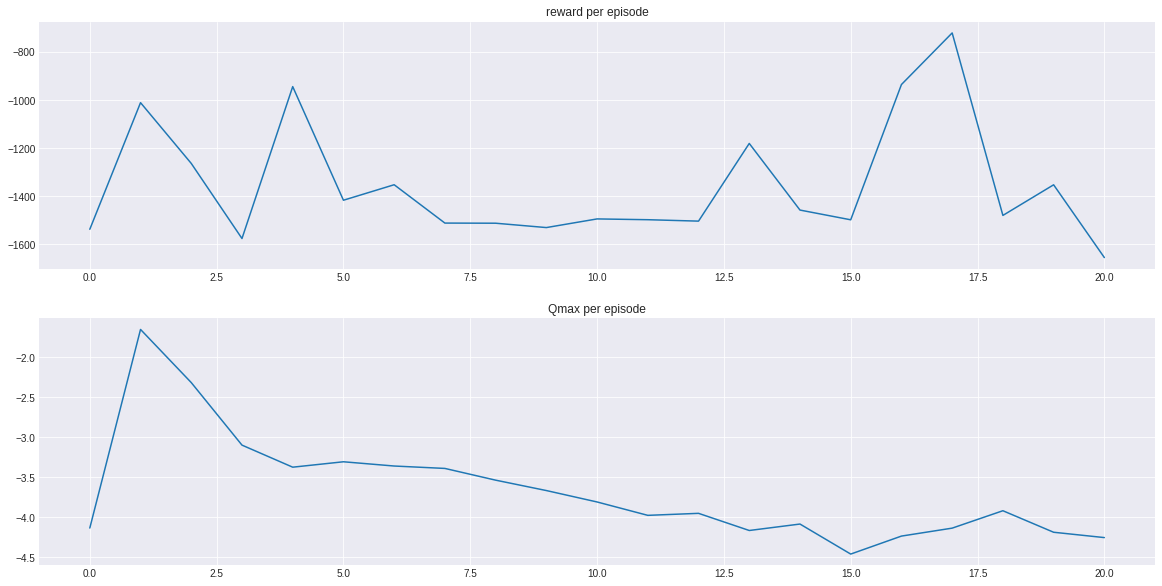

Reward: -1637 | Episode: 21 | Qmax: -4.3979

Reward: -1494 | Episode: 22 | Qmax: -4.1092

Reward: -1183 | Episode: 23 | Qmax: -4.2638

Reward: -1739 | Episode: 24 | Qmax: -4.0509

Reward: -1014 | Episode: 25 | Qmax: -4.6540

Reward: -1096 | Episode: 26 | Qmax: -4.0414

Reward: -1243 | Episode: 27 | Qmax: -4.0456

Reward: -1186 | Episode: 28 | Qmax: -4.2811

Reward: -1100 | Episode: 29 | Qmax: -4.4454

Reward: -1317 | Episode: 30 | Qmax: -4.6705

Reward: -857 | Episode: 31 | Qmax: -4.4876

Reward: -1350 | Episode: 32 | Qmax: -4.1611

Reward: -808 | Episode: 33 | Qmax: -4.0350

Reward: -1069 | Episode: 34 | Qmax: -3.7164

Reward: -1238 | Episode: 35 | Qmax: -3.8356

Reward: -1210 | Episode: 36 | Qmax: -3.8199

Reward: -1565 | Episode: 37 | Qmax: -4.0980

Reward: -1011 | Episode: 38 | Qmax: -4.0540

Reward: -1065 | Episode: 39 | Qmax: -4.5969

Reward: -1086 | Episode: 40 | Qmax: -4.4578



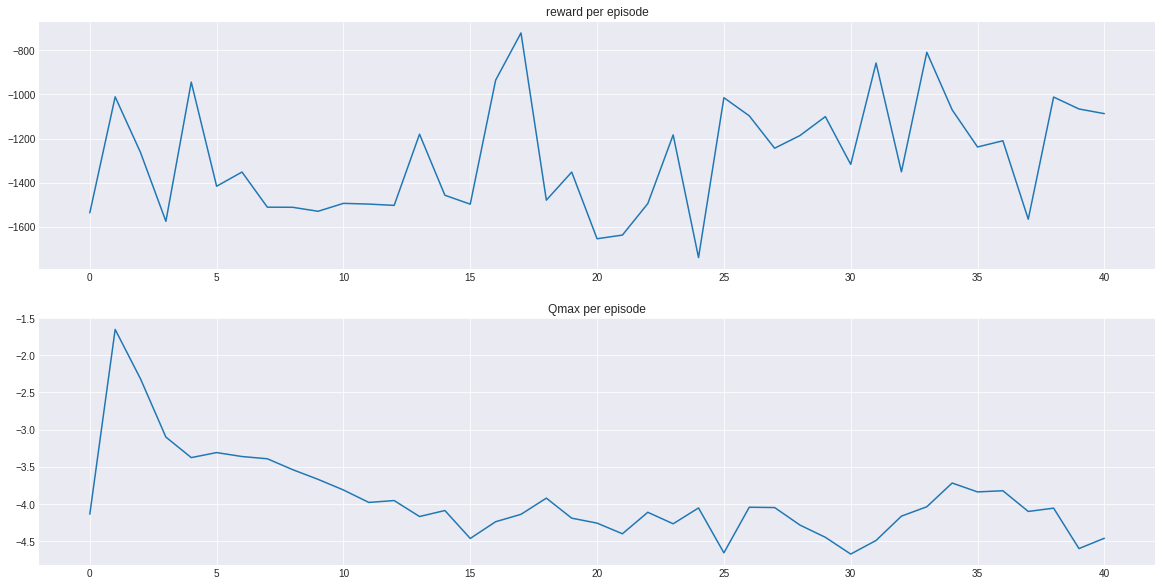

Reward: -1116 | Episode: 41 | Qmax: -4.9253

Reward: -813 | Episode: 42 | Qmax: -4.1123

Reward: -1201 | Episode: 43 | Qmax: -3.8578

Reward: -999 | Episode: 44 | Qmax: -4.6342

Reward: -782 | Episode: 45 | Qmax: -4.5990

Reward: -651 | Episode: 46 | Qmax: -4.1354

Reward: -1503 | Episode: 47 | Qmax: -3.3122

Reward: -672 | Episode: 48 | Qmax: -3.3671

Reward: -503 | Episode: 49 | Qmax: -1.7131

Reward: -272 | Episode: 50 | Qmax: -0.9378

Reward: -133 | Episode: 51 | Qmax: 0.1817

Reward: -647 | Episode: 52 | Qmax: 0.4148

Reward: -397 | Episode: 53 | Qmax: 0.9986

Reward: -721 | Episode: 54 | Qmax: 1.5086

Reward: -132 | Episode: 55 | Qmax: 2.1047

Reward: -131 | Episode: 56 | Qmax: 2.7123

Reward: -678 | Episode: 57 | Qmax: 2.9520

Reward: -269 | Episode: 58 | Qmax: 3.0300

Reward: -130 | Episode: 59 | Qmax: 3.2440

Reward: -134 | Episode: 60 | Qmax: 3.3923



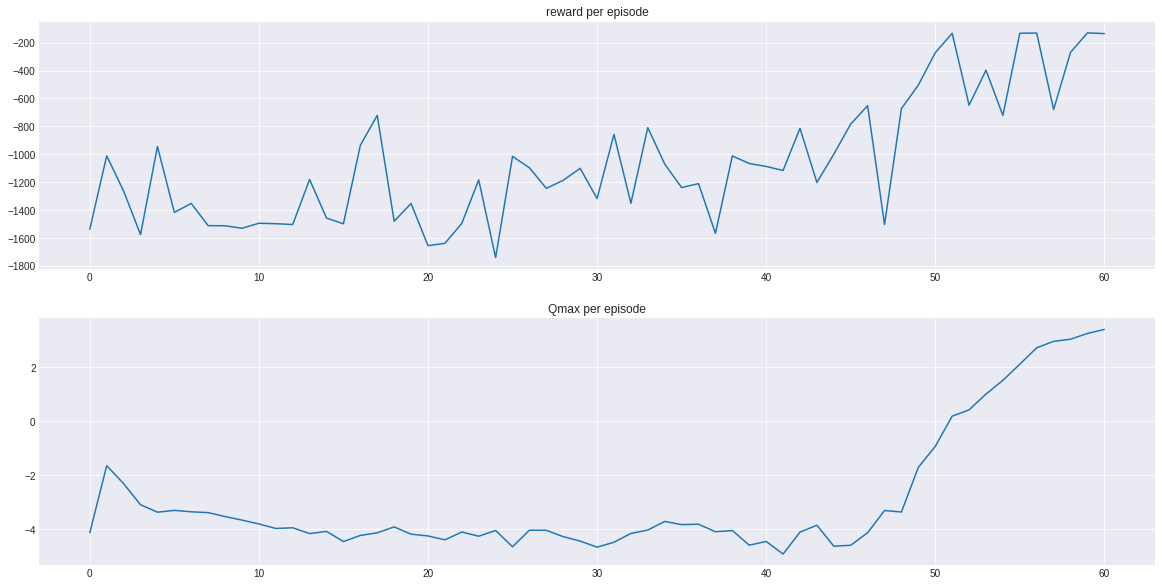

Reward: -131 | Episode: 61 | Qmax: 3.5656

Reward: -284 | Episode: 62 | Qmax: 3.6631

Reward: -643 | Episode: 63 | Qmax: 3.6980

Reward: -962 | Episode: 64 | Qmax: 3.7751

Reward: -981 | Episode: 65 | Qmax: 3.7934

Reward: -944 | Episode: 66 | Qmax: 3.8632

Reward: -810 | Episode: 67 | Qmax: 3.9152

Reward: -2 | Episode: 68 | Qmax: 4.1444

Reward: -132 | Episode: 69 | Qmax: 4.3329

Reward: -926 | Episode: 70 | Qmax: 4.4580

Reward: -917 | Episode: 71 | Qmax: 4.5447

Reward: -901 | Episode: 72 | Qmax: 4.6855

Reward: -131 | Episode: 73 | Qmax: 4.7866

Reward: -1057 | Episode: 74 | Qmax: 4.9781

Reward: -1141 | Episode: 75 | Qmax: 5.0550

Reward: -921 | Episode: 76 | Qmax: 5.2302

Reward: -914 | Episode: 77 | Qmax: 5.1950

Reward: -1141 | Episode: 78 | Qmax: 5.3096

Reward: -991 | Episode: 79 | Qmax: 5.4368

Reward: -785 | Episode: 80 | Qmax: 5.5705



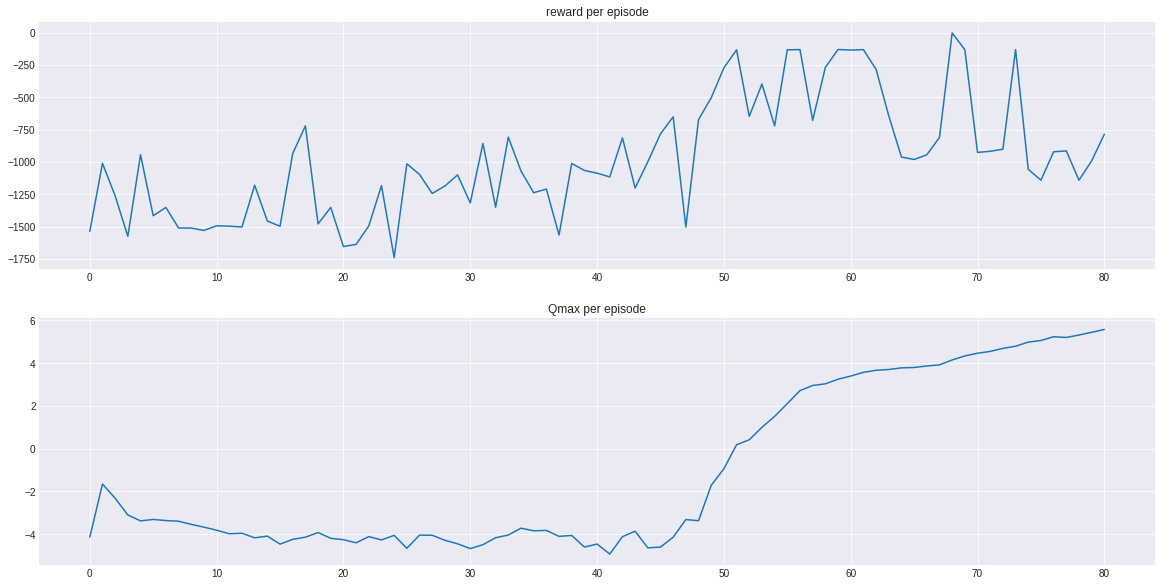

Reward: -5 | Episode: 81 | Qmax: 5.5999

Reward: 0 | Episode: 82 | Qmax: 5.68243

Reward: -3 | Episode: 83 | Qmax: 5.7330

Reward: -952 | Episode: 84 | Qmax: 5.7041

Reward: -1021 | Episode: 85 | Qmax: 5.8730

Reward: -951 | Episode: 86 | Qmax: 5.9324

Reward: -1065 | Episode: 87 | Qmax: 5.8757

Reward: -908 | Episode: 88 | Qmax: 5.9645

Reward: -931 | Episode: 89 | Qmax: 6.0638

Reward: -1023 | Episode: 90 | Qmax: 5.9567

Reward: -771 | Episode: 91 | Qmax: 5.7979

Reward: -509 | Episode: 92 | Qmax: 5.9204

Reward: -128 | Episode: 93 | Qmax: 6.1545

Reward: -276 | Episode: 94 | Qmax: 6.1083

Reward: -117 | Episode: 95 | Qmax: 6.2553

Reward: -653 | Episode: 96 | Qmax: 6.2667

Reward: -1 | Episode: 97 | Qmax: 6.2215

Reward: -1079 | Episode: 98 | Qmax: 6.4118

Reward: -935 | Episode: 99 | Qmax: 6.3695

Reward: -131 | Episode: 100 | Qmax: 6.4535



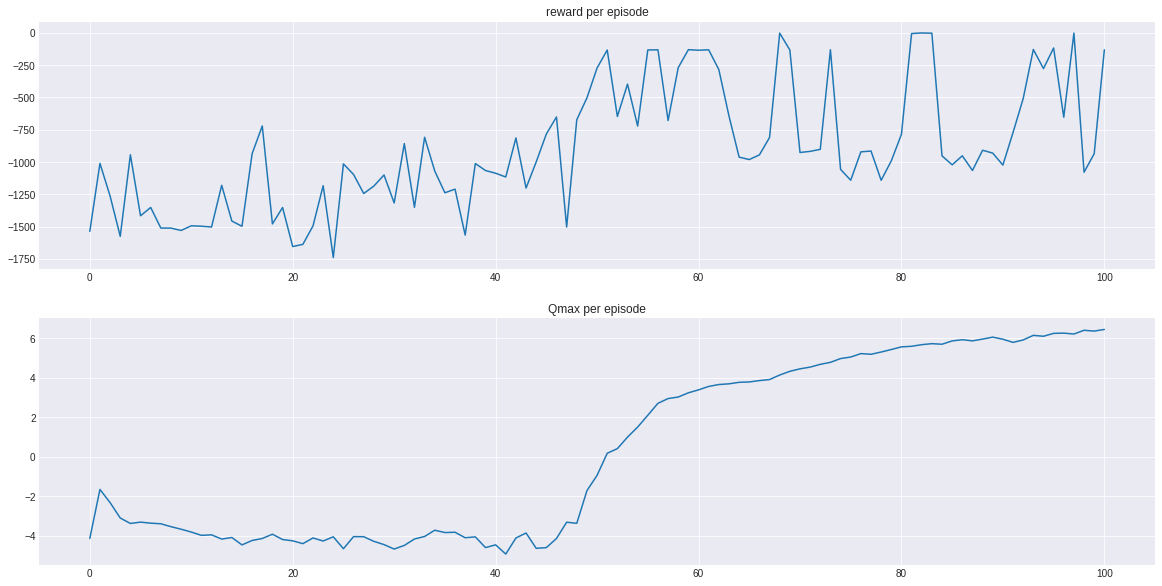

Reward: -375 | Episode: 101 | Qmax: 6.5008

Reward: -130 | Episode: 102 | Qmax: 6.5819

Reward: -893 | Episode: 103 | Qmax: 6.6294

Reward: -383 | Episode: 104 | Qmax: 6.7364

Reward: -1 | Episode: 105 | Qmax: 6.7159

Reward: -125 | Episode: 106 | Qmax: 6.8482

Reward: -702 | Episode: 107 | Qmax: 6.9690

Reward: -502 | Episode: 108 | Qmax: 7.0509

Reward: -258 | Episode: 109 | Qmax: 7.3589

Reward: -475 | Episode: 110 | Qmax: 7.5076

Reward: -377 | Episode: 111 | Qmax: 7.6973

Reward: -127 | Episode: 112 | Qmax: 7.9468

Reward: -269 | Episode: 113 | Qmax: 7.9502

Reward: -439 | Episode: 114 | Qmax: 8.0451

Reward: -364 | Episode: 115 | Qmax: 8.1384

Reward: -275 | Episode: 116 | Qmax: 8.4650

Reward: -263 | Episode: 117 | Qmax: 8.5425

Reward: -234 | Episode: 118 | Qmax: 8.8402

Reward: -1 | Episode: 119 | Qmax: 8.9375

Reward: -242 | Episode: 120 | Qmax: 9.1139



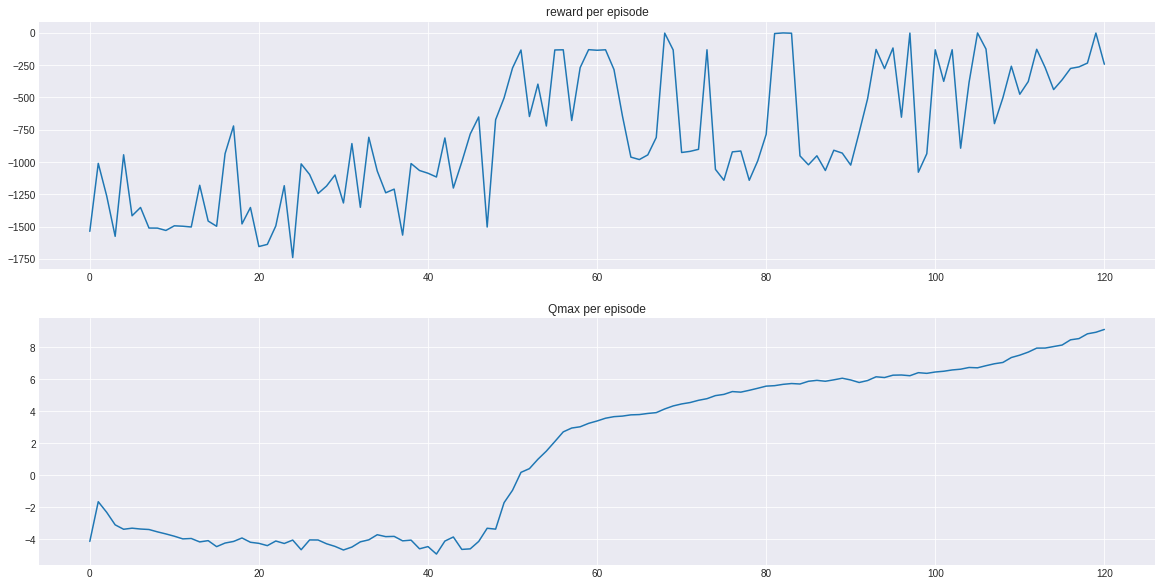

Reward: -653 | Episode: 121 | Qmax: 9.0610

Reward: -504 | Episode: 122 | Qmax: 9.37972

Reward: -1 | Episode: 123 | Qmax: 9.4407

Reward: -122 | Episode: 124 | Qmax: 9.5073

Reward: -265 | Episode: 125 | Qmax: 9.6940

Reward: -384 | Episode: 126 | Qmax: 9.93103

Reward: -268 | Episode: 127 | Qmax: 10.0842

Reward: -258 | Episode: 128 | Qmax: 10.5490

Reward: -811 | Episode: 129 | Qmax: 10.4773

Reward: -900 | Episode: 130 | Qmax: 10.6932

Reward: -879 | Episode: 131 | Qmax: 10.7153

Reward: -956 | Episode: 132 | Qmax: 11.0736

Reward: -744 | Episode: 133 | Qmax: 11.4089

Reward: -247 | Episode: 134 | Qmax: 11.4521

Reward: -2 | Episode: 135 | Qmax: 11.8671

Reward: -374 | Episode: 136 | Qmax: 12.1028

Reward: -134 | Episode: 137 | Qmax: 12.1686

Reward: -126 | Episode: 138 | Qmax: 12.7809

Reward: -382 | Episode: 139 | Qmax: 12.8367

Reward: -377 | Episode: 140 | Qmax: 12.1798



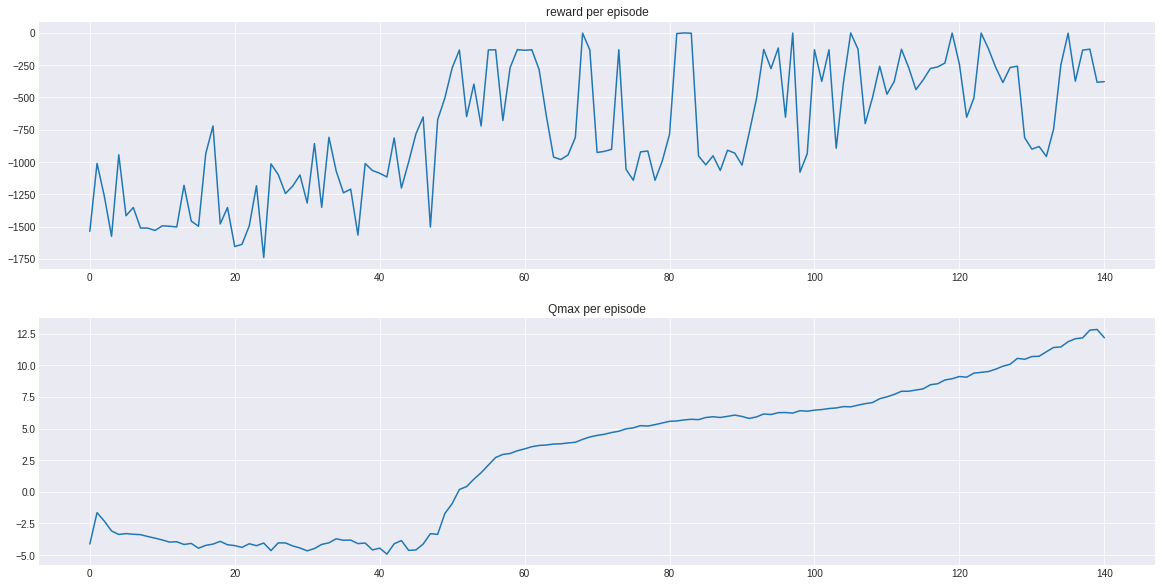

Reward: -5 | Episode: 141 | Qmax: 12.7859

Reward: -121 | Episode: 142 | Qmax: 12.7165

Reward: -262 | Episode: 143 | Qmax: 13.0724

Reward: -388 | Episode: 144 | Qmax: 13.6770

Reward: -384 | Episode: 145 | Qmax: 13.5121

Reward: -252 | Episode: 146 | Qmax: 14.1336

Reward: -388 | Episode: 147 | Qmax: 13.8763

Reward: -244 | Episode: 148 | Qmax: 14.3333

Reward: -131 | Episode: 149 | Qmax: 14.7130

Reward: -247 | Episode: 150 | Qmax: 14.5740

Reward: -1194 | Episode: 151 | Qmax: 14.7020

Reward: -1181 | Episode: 152 | Qmax: 14.5767

Reward: -132 | Episode: 153 | Qmax: 14.7379

Reward: -7 | Episode: 154 | Qmax: 15.0614

Reward: -334 | Episode: 155 | Qmax: 15.2262

Reward: -128 | Episode: 156 | Qmax: 15.2860

Reward: -1031 | Episode: 157 | Qmax: 15.6144

Reward: -13 | Episode: 158 | Qmax: 15.4551

Reward: -10 | Episode: 159 | Qmax: 15.8010

Reward: -159 | Episode: 160 | Qmax: 15.8837



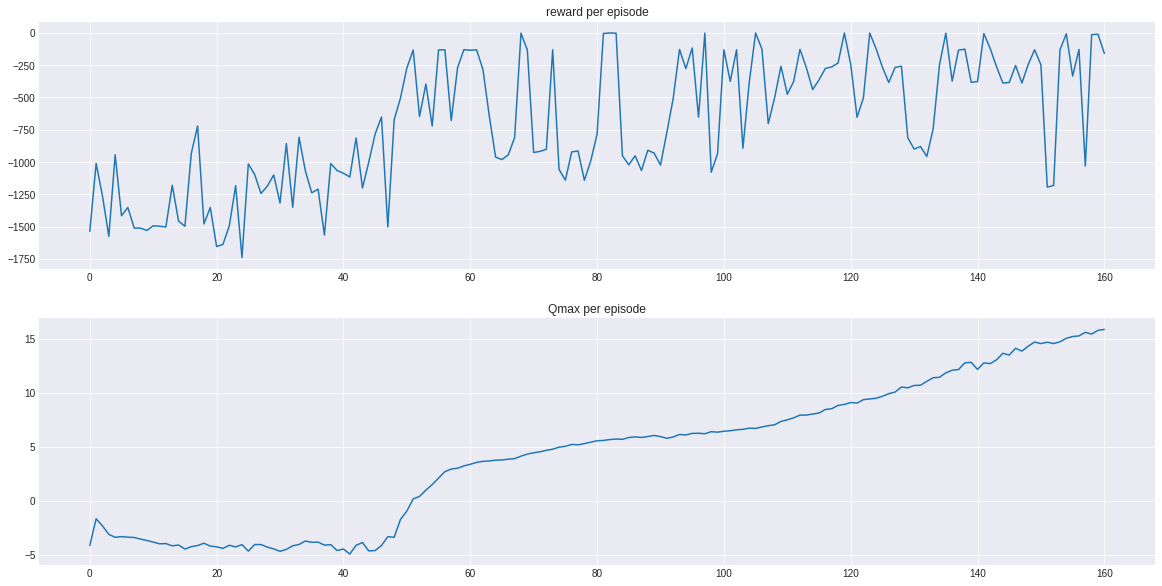

Reward: -817 | Episode: 161 | Qmax: 16.0309

Reward: -261 | Episode: 162 | Qmax: 16.2873

Reward: -131 | Episode: 163 | Qmax: 16.3255

Reward: -249 | Episode: 164 | Qmax: 16.3630

Reward: -369 | Episode: 165 | Qmax: 16.7928

Reward: -134 | Episode: 166 | Qmax: 16.6987

Reward: -132 | Episode: 167 | Qmax: 16.8485

Reward: -132 | Episode: 168 | Qmax: 16.8904

Reward: -344 | Episode: 169 | Qmax: 16.8871

Reward: -408 | Episode: 170 | Qmax: 17.0787

Reward: -136 | Episode: 171 | Qmax: 16.9677

Reward: -240 | Episode: 172 | Qmax: 17.2373

Reward: -355 | Episode: 173 | Qmax: 17.4510

Reward: -130 | Episode: 174 | Qmax: 17.6099

Reward: -256 | Episode: 175 | Qmax: 17.4893

Reward: -128 | Episode: 176 | Qmax: 17.9121

Reward: -130 | Episode: 177 | Qmax: 17.9843

Reward: -12 | Episode: 178 | Qmax: 18.0480

Reward: -499 | Episode: 179 | Qmax: 17.8417

Reward: -503 | Episode: 180 | Qmax: 18.0056



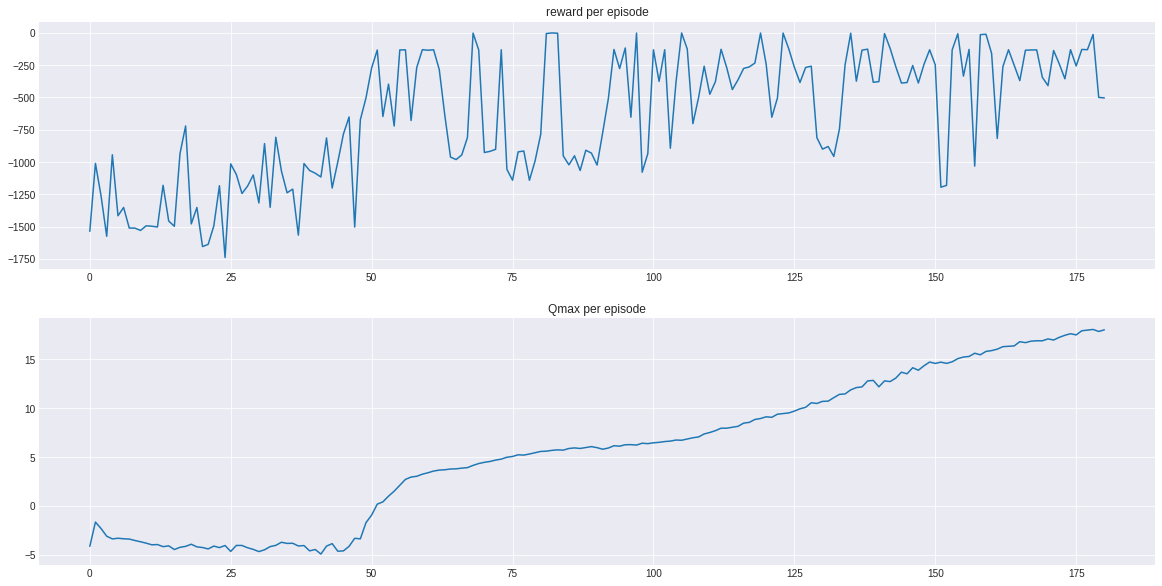

Reward: -365 | Episode: 181 | Qmax: 18.5772

Reward: -260 | Episode: 182 | Qmax: 18.6069

Reward: -123 | Episode: 183 | Qmax: 19.0419

Reward: -225 | Episode: 184 | Qmax: 18.5829

Reward: -257 | Episode: 185 | Qmax: 17.9896

Reward: -134 | Episode: 186 | Qmax: 18.5007

Reward: -143 | Episode: 187 | Qmax: 19.0966

Reward: -387 | Episode: 188 | Qmax: 19.6292

Reward: -521 | Episode: 189 | Qmax: 20.0028

Reward: -121 | Episode: 190 | Qmax: 20.1908

Reward: -255 | Episode: 191 | Qmax: 20.9796

Reward: -140 | Episode: 192 | Qmax: 20.9181

Reward: -126 | Episode: 193 | Qmax: 20.8926

Reward: -134 | Episode: 194 | Qmax: 21.0456

Reward: -510 | Episode: 195 | Qmax: 20.9254

Reward: -1035 | Episode: 196 | Qmax: 21.7432

Reward: -1127 | Episode: 197 | Qmax: 21.5426

Reward: -1026 | Episode: 198 | Qmax: 21.4905

Reward: -1030 | Episode: 199 | Qmax: 21.6307



In [16]:
summary_ops, summary_vars = build_summaries()

tf.reset_default_graph()
sess = tf.Session(config=config)
writer = tf.summary.FileWriter(summaryFile, sess.graph)

actor = Actor(sess, nObs=nObs, nAct=nAct, lr=actorLr, tau=tau, nodes=actorNodes, \
    batchSize=batchSize, actionBound=actionBound, trainable=True, layer_norm=layer_norm)

critic = Critic(sess, nObs=nObs, nAct=nAct, lr=criticLr, tau=tau, nodes=criticNodes, \
            gamma=gamma, trainable=True, layer_norm=layer_norm)

actorNoise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(nAct))

sess.run(tf.global_variables_initializer())

actor.update_target_net()
critic.update_target_net()

replayBuffer = ReplayBuffer(bufferSize)

R, Qmax = [], []

for nEp in range(episode):
    s = env.reset()
    
    ep_reward = 0
    ep_Qmax = 0
    for nStep in range(step):
        a = actor.gen_action(np.reshape(s, (1, actor.nObs))) + actorNoise()
        
        s2 , r, done, info = env.step(a[0])
            
        replayBuffer.add(np.reshape(s, (actor.nObs,)), np.reshape(a, (actor.nAct,)),\
                         r, done, np.reshape(s2, (actor.nObs, )))
        
        if replayBuffer.size() > batchSize:
            sBatch, aBatch, rBatch, doneBatch, s2Batch = \
                            replayBuffer.sample_batch(batchSize)
            
            targetQ = critic.target_gen_value(s2Batch, \
                        actor.gen_action(s2Batch))
            
            for i in range(batchSize):
                if not doneBatch[i]:
                    rBatch[i] = rBatch[i] + critic.gamma*targetQ[i]
                    
            predictedQ, _ = critic.train(sBatch, aBatch, np.reshape(rBatch, (batchSize, 1)))
            
            ep_Qmax += np.amax(predictedQ)
            
            grads = critic.get_action_grads(sBatch, actor.gen_action(sBatch))
            actor.train(sBatch, grads[0])
            
            actor.update_target_net()
            critic.update_target_net()
            
        s = s2
        ep_reward += r
        
        print('\rReward: {:d} | Episode: {:d} | Qmax: {:.4f}'.format(int(ep_reward), \
                    nEp, (ep_Qmax / (float(nStep)+0.1))), end='')
            
    if done:
        print('\n')
        Qmax.append(ep_Qmax / (float(nStep)+0.1))
        R.append(ep_reward)
        
#         summary_str = sess.run(summary_ops, feed_dict=\
#                               {summary_vars[0]: 1,
#                                summary_vars[1]: 1})
#         writer.add_summary(summary_str, nEp)
#         writer.flush()
        
        if nEp != 0 and nEp % 20 == 0:
            fig = plt.figure(figsize=(20, 10))
            plt.style.use('seaborn-darkgrid')
            plt.subplot(211)
            plt.plot(range(len(R)), R)
            plt.title("reward per episode")
            plt.subplot(212)
            plt.plot(range(len(Qmax)), Qmax)
            plt.title("Qmax per episode")
            plt.savefig("./figs/results/results_" + str(nEp) + ".png")
            plt.show()

## Issues when building actor & critic net.

* <U>**Assigning weight and bias variables is better as the above than the below**</U>

x = tf.layers.dense(obs, units=self.nodes[0], activation=tf.nn.relu,    trainable=self.trainable, name='p_fc0') 
                         
x = tf.layers.dense(x, units=self.nodes[1], activation=tf.nn.relu, trainable=self.trainable, name='p_fc1')     
                         
action = tf.layers.dense(x, units=self.nAct, activation=tf.nn.relu,
trainable=self.trainable, name='p_fc2')
                         
scaledAction = tf.multiply(action, self.actionBound)

-------------------------------------------------------------------------


* <U>**The below "batch normalization" does not work well**</U> 

L1 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.add(tf.matmul(obs, W1), b1)))

L2 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.add(tf.matmul(L1, W2), b2)))

-------------------------------------------------------------------------


* <U>**Getting trainable variables of networks:**</U>

self.netParams = tf.trainable_variables()

self.target_netParams = tf.trainable_variables()[len(self.netParams):]
        
self.netParams = tf.trainable_variables()[numActorParams:]

self.target_netParams = tf.trainable_variables()[len(self.netParams) + numActorParams:]

> **The above method is not good, b/c it requires the number of trainable variables in each networks(actor, target_actor, critic, target_critic). Thus, the below method is better !!! 
In this way, it just requires the scope of each network to classify.**

self.netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'actor')

self.target_netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'target_actor')

self.netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='critic')
  
self.target_netParams = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_critic')
  

-------------------------------------------------------------------------
*